In [1]:
# import libraries

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import arima
from statsmodels.graphics.tsaplots import acf, pacf
# for auto arima
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# read in the electricity bill dataset
# two columns. First is date, second is amount

df = pd.read_csv('datasets/ebillMonthly4.csv', index_col='BilledMonth', parse_dates=['BilledMonth'])
# explore dataset
df.head()
df.tail()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, Jan-00 to Mar-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Amount  195 non-null    float64
dtypes: float64(1)
memory usage: 3.0+ KB


In [3]:
# create a series with just the billed amount
y = df['Amount']

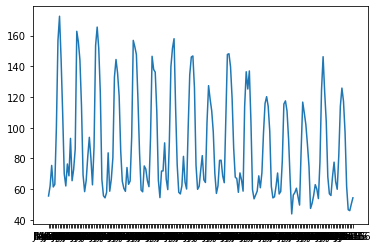

In [4]:
# plot
plt.plot(y)
plt.show()

In [5]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.325471
p-value: 0.617440
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [6]:
# difference once
df["Diff_Amount"] = df["Amount"].diff()
diff_values = df["Diff_Amount"].values
y_diff = diff_values[~np.isnan(diff_values)]
y = y_diff

In [7]:
df.head(10)

,Amount,Diff_Amount
BilledMonth,,
Jan-00,55.46,NaN
Feb-00,61.99,6.53
Mar-00,75.38,13.39
Apr-00,61.34,-14.04
May-00,63.07,1.73
Jun-00,99.97,36.90
Jul-00,156.81,56.84
Aug-00,172.65,15.84
Sep-00,144.74,-27.91


In [8]:
# Stationarity Test
result = adfuller(y)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.532035
p-value: 0.000000
Critical Values:
	1%: -3.467
	5%: -2.878
	10%: -2.575


In [11]:
[accf, qstat, pvalue] = acf(y, nlags=4, qstat=True, fft=False, alpha=None, missing='none')

In [12]:
accf

array([ 1.        ,  0.41464458, -0.07287765, -0.33961022, -0.35232303])

In [13]:
pvalue

array([5.88322905e-09, 2.60729314e-08, 1.66291481e-12, 4.60207736e-17])

In [14]:
qstat

array([33.87290711, 34.92473635, 57.88547931, 82.72746277])

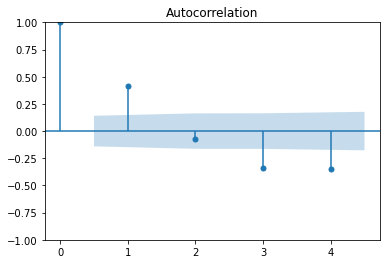

In [15]:
# plot acf, pacf
#plt.plot(y)
plot_acf(y, lags=4, alpha=0.05)
plt.show()

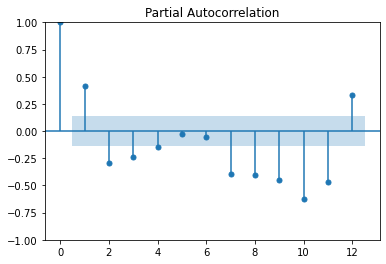

In [16]:
plot_pacf(y, lags=12, method='ols')
plt.show()

In [17]:
# train, test split
train = y[0:-12]
test = y[-12:]

In [18]:
# grid search and find best parameters
stepwise_fit = auto_arima(train, start_p = 0, 
                          start_q = 0,	max_p = 3, max_q = 3, 
                          m = 12, start_P = 0, max_P = 3,seasonal = True,
                          start_Q = 0, max_Q = 3,d = 1, D = 0, trace = True, 
                          error_action ='ignore', 
                          # we don't want to know if an order does not work 
                          suppress_warnings = True, 
                          # we don't want convergence warnings
                          information_criterion='aic',
                          stepwise = True)# set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1691.515, Time=0.55 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1502.771, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1689.515, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1691.876, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1465.858, Time=0.30 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1607.492, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1467.824, Time=0.52 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1467.797, Time=0.59 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1578.420, Time=0.29 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=1467.664, Time=0.93 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1532.890, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1448.655, Time=0.29 sec
 ARIMA(2,1,0)(0,0,1)[12] inte

In [20]:
# To print the summary 
stepwise_fit.summary() 
# use the recommended fit
model = arima.model.ARIMA(train, order=(3,1,0), seasonal_order=(1,0,1,12))
model_fitted = model.fit()
model_fitted.params
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  182
Model:             ARIMA(3, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -713.720
Date:                            Mon, 20 Dec 2021   AIC                           1439.441
Time:                                    13:56:26   BIC                           1458.632
Sample:                                         0   HQIC                          1447.221
                                            - 182                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8430      0.065    -12.982      0.000      -0.970      -0.716
ar.L2         -0.4954      0.082     -6.044      0.000      -0.656      -0.335
ar.L3         -0.2226      0.078     -2.843      0.004      -0.376      -0.069
ar.S.L12       0.9907      0.005    218.404      0.000       0.982       1.000
ma.S.L12      -0.6459      0.066     -9.794      0.000      -0.775      -0.517
sigma2       131.5735     16.834      7.816      0.000      98.579     164.568
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.36   Prob(JB):                         0.30
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

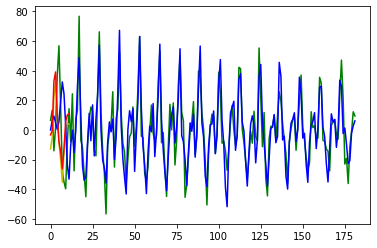

In [21]:
# plot train, test, in sample fitted values and out of sample forecast
plt.plot(train, color="g")
plt.plot(test, color="y")
plt.plot(model_fitted.fittedvalues, color="b")
plt.plot(model_fitted.forecast(steps=len(test)), color="r")
plt.show()